In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgbm

In [74]:
a=np.array([0,0.1,0.01,0.001,0.008])
round=False
if type(round)==int:
    a=np.round(a,round)
    print('y')
a

array([0.   , 0.1  , 0.01 , 0.001, 0.008])

In [67]:
type(round)

int

In [47]:
sns.set_theme()
plt.rcParams["figure.figsize"] = (10,5)

In [3]:
# Dataset class

class Dataset:
    def __init__(self, df, cat_cols, num_cols, target_col):
        self.df = df
        self.cat_cols = cat_cols
        self.cat_encoded_cols = [col + "_encoded" for col in cat_cols]
        self.num_cols = num_cols
        self.target_col = target_col

    def create_lgbm_dataset(self, train_valid_test):
        assert train_valid_test in ("TRAIN", "VALID", "TEST", "ALL")
        if train_valid_test == 'ALL':
            data = self.df.loc[:, self.cat_encoded_cols + self.num_cols]
            label = self.df.loc[:, self.target_col].rename()
        else:
            data = self.df.loc[self.df["train_valid_test"] == train_valid_test, self.cat_encoded_cols + self.num_cols]
            label = self.df.loc[self.df["train_valid_test"] == train_valid_test, self.target_col]

        return lgbm.Dataset(
            data = data,
            label = label,
            feature_name = self.cat_encoded_cols + self.num_cols,
            categorical_feature = self.cat_encoded_cols,
        )

In [4]:
df = pd.read_pickle('./saved/data/preprocessed_df.pkl')
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,global_sold_lag0_ma7,global_sold_lag0_ma7_diff,global_sold_lag0_ma28,global_sold_lag0_ma28_diff,global_sold_lag1_ma7,global_sold_lag1_ma7_diff,global_sold_lag1_ma28,global_sold_lag1_ma28_diff,sold_lag1,avg_sold_per_id
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1799,0.0,2016-01-01,11548,...,35064.142857,5797.628571,36218.607143,-197.714286,30401.714286,1213.634783,36416.321429,179.642857,2.0,0.804196
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1800,0.0,2016-01-02,11549,...,35972.714286,1129.788820,36136.892857,-81.714286,35064.142857,5797.628571,36218.607143,-197.714286,0.0,0.804196
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1801,0.0,2016-01-03,11549,...,37253.000000,1592.007453,35991.357143,-145.535714,35972.714286,1129.788820,36136.892857,-81.714286,0.0,0.804196
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1802,1.0,2016-01-04,11549,...,38214.285714,1195.337888,36037.250000,45.892857,37253.000000,1592.007453,35991.357143,-145.535714,0.0,0.804196
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1803,0.0,2016-01-05,11549,...,38701.857143,606.284472,36122.714286,85.464286,38214.285714,1195.337888,36037.250000,45.892857,1.0,0.804196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5213272,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1965,NaN,2016-06-15,11620,...,0.000000,0.000000,6620.392857,-1324.857143,0.000000,0.000000,7945.250000,-1384.892857,NaN,0.062937
5213273,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1966,NaN,2016-06-16,11620,...,0.000000,0.000000,5300.285714,-1320.107143,0.000000,0.000000,6620.392857,-1324.857143,NaN,0.062937
5213274,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1967,NaN,2016-06-17,11620,...,0.000000,0.000000,3780.571429,-1519.714286,0.000000,0.000000,5300.285714,-1320.107143,NaN,0.062937
5213275,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1968,NaN,2016-06-18,11621,...,0.000000,0.000000,1940.642857,-1839.928571,0.000000,0.000000,3780.571429,-1519.714286,NaN,0.062937


In [5]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'date', 'wm_yr_wk', 'weekday', 'is_holiday', 'is_weekend',
       'sell_price', 'sell_price_diff', 'id_sold_lag0_ma7',
       'id_sold_lag0_ma7_diff', 'id_sold_lag0_ma28', 'id_sold_lag0_ma28_diff',
       'id_sold_lag1_ma7', 'id_sold_lag1_ma7_diff', 'id_sold_lag1_ma28',
       'id_sold_lag1_ma28_diff', 'global_sold_lag0_ma7',
       'global_sold_lag0_ma7_diff', 'global_sold_lag0_ma28',
       'global_sold_lag0_ma28_diff', 'global_sold_lag1_ma7',
       'global_sold_lag1_ma7_diff', 'global_sold_lag1_ma28',
       'global_sold_lag1_ma28_diff', 'sold_lag1', 'avg_sold_per_id'],
      dtype='object')

In [6]:
# feature selection
num_col_1= ["sell_price", "sell_price_diff", "avg_sold_per_id"]
num_col_2= ['sold_lag1']
num_col_3= [
    'id_sold_lag1_ma7', 'id_sold_lag1_ma7_diff', 
    'id_sold_lag1_ma28', 'id_sold_lag1_ma28_diff',
    'global_sold_lag1_ma7', 'global_sold_lag1_ma7_diff', 
    'global_sold_lag1_ma28', 'global_sold_lag1_ma28_diff'
]
num_cols = num_col_1+num_col_2+num_col_3
cat_cols = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ['weekday','is_holiday','is_weekend']

In [7]:
target = 'sold'     # residual = sold - id_sold_lag1_ma7 -> target = ['sold', 'residual_id_sold_lag1_ma7', 'residual_id_sold_lag1_ma28', 'residual_id_sold_lag0_ma7', 'residual_id_sold_lag0_ma28']

# create target
def get_target(df, target):
    if target != 'sold' and not re.search('residual_id_sold_lag\d_ma\d', target):
        raise ValueError("target must be 'sold' or 'residual_id_sold_lag\d_ma\d'")
    elif 'residual' in target:
        df[target] = df['sold'] - df[target.split('residual_')[1]]
    else:
        pass
    return df
        
df = get_target(df, target)
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,global_sold_lag0_ma7,global_sold_lag0_ma7_diff,global_sold_lag0_ma28,global_sold_lag0_ma28_diff,global_sold_lag1_ma7,global_sold_lag1_ma7_diff,global_sold_lag1_ma28,global_sold_lag1_ma28_diff,sold_lag1,avg_sold_per_id
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1799,0.0,2016-01-01,11548,...,35064.142857,5797.628571,36218.607143,-197.714286,30401.714286,1213.634783,36416.321429,179.642857,2.0,0.804196
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1800,0.0,2016-01-02,11549,...,35972.714286,1129.788820,36136.892857,-81.714286,35064.142857,5797.628571,36218.607143,-197.714286,0.0,0.804196
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1801,0.0,2016-01-03,11549,...,37253.000000,1592.007453,35991.357143,-145.535714,35972.714286,1129.788820,36136.892857,-81.714286,0.0,0.804196
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1802,1.0,2016-01-04,11549,...,38214.285714,1195.337888,36037.250000,45.892857,37253.000000,1592.007453,35991.357143,-145.535714,0.0,0.804196
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1803,0.0,2016-01-05,11549,...,38701.857143,606.284472,36122.714286,85.464286,38214.285714,1195.337888,36037.250000,45.892857,1.0,0.804196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5213272,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1965,NaN,2016-06-15,11620,...,0.000000,0.000000,6620.392857,-1324.857143,0.000000,0.000000,7945.250000,-1384.892857,NaN,0.062937
5213273,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1966,NaN,2016-06-16,11620,...,0.000000,0.000000,5300.285714,-1320.107143,0.000000,0.000000,6620.392857,-1324.857143,NaN,0.062937
5213274,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1967,NaN,2016-06-17,11620,...,0.000000,0.000000,3780.571429,-1519.714286,0.000000,0.000000,5300.285714,-1320.107143,NaN,0.062937
5213275,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1968,NaN,2016-06-18,11621,...,0.000000,0.000000,1940.642857,-1839.928571,0.000000,0.000000,3780.571429,-1519.714286,NaN,0.062937


In [8]:
# Label encoding for lgbm
labels = {}
for col in cat_cols:
    df[col+'_encoded'] = df[col].astype('category')
    label = dict(zip(df[col+'_encoded'].cat.codes, df[col+'_encoded']))
    labels[col] = label
    df[col+'_encoded'] = df[col+'_encoded'].cat.codes

In [9]:
# train valid test split
df.loc[df.d<1914, 'train_valid_test'] = 'TRAIN'
df.loc[(df.d>=1914) & (df.d<1942), 'train_valid_test'] = 'VALID'
df.loc[df.d>=1942, 'train_valid_test'] = 'TEST'

dataset_all = Dataset(df, cat_cols, num_cols, target)

In [14]:
lgbm_params= {
    "objective" : "tweedie",
    "tweedie_variance_power": 1.25,
    "alpha" : 0.9,
    "metric" : ["rmse"],
    "force_row_wise" : True,
    "learning_rate" : 0.07,
    "bagging_freq" : 3,
    "bagging_fraction" : 0.5,
    "lambda_l2" : 0.1,
    "num_leaves" : 256,
    "min_data_in_leaf": 128,
}
lgbm_trainer_args= {
    "num_boost_round": 1000,
    "early_stopping_rounds": 100,
    "verbose_eval": 50
}

lgbm_model = lgbm.train(
    lgbm_params,
    **lgbm_trainer_args,
    train_set=dataset_all.create_lgbm_dataset("TRAIN"),
    valid_sets=dataset_all.create_lgbm_dataset("VALID"),
)

c:\Anaconda3\envs\forecast\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Anaconda3\envs\forecast\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Anaconda3\envs\forecast\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 5509
[LightGBM] [Info] Number of data points in the train set: 3505837, number of used features: 20


c:\Anaconda3\envs\forecast\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Anaconda3\envs\forecast\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 0.303852
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 1.99416
[100]	valid_0's rmse: 1.98536
[150]	valid_0's rmse: 1.98821
Early stopping, best iteration is:
[82]	valid_0's rmse: 1.98305


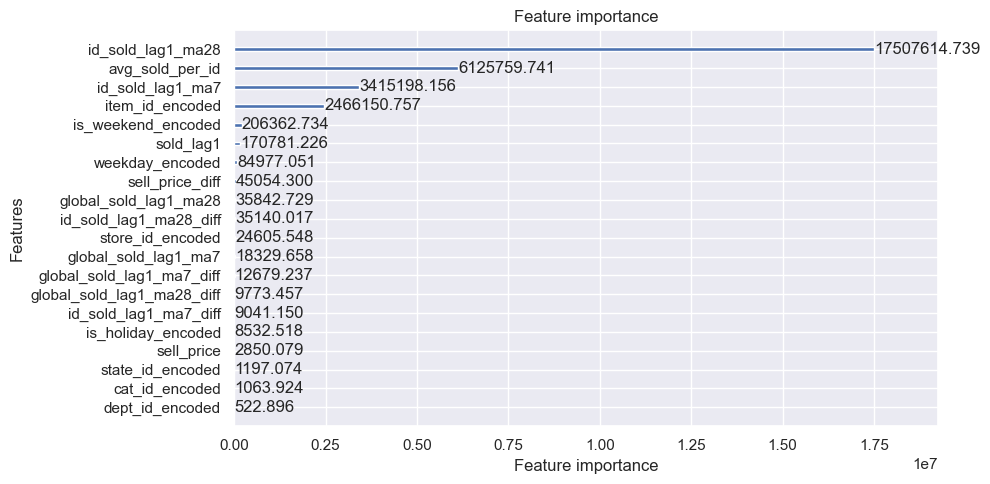

In [15]:
ax = lgbm.plot_importance(lgbm_model, importance_type='gain')
ax.figure.tight_layout()

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

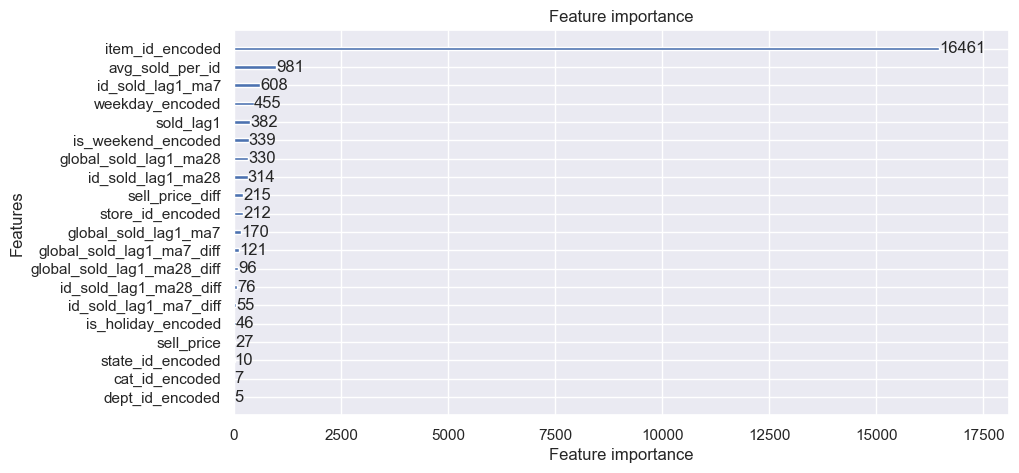

In [16]:
lgbm.plot_importance(lgbm_model, importance_type='split')

In [17]:
# predict
y_pred = lgbm_model.predict(dataset_all.create_lgbm_dataset("ALL").data)
y_pred = np.clip(y_pred, a_min=0, a_max=None)
y_pred = np.round(y_pred)

In [18]:
y_pred = pd.Series(y_pred, name="y_pred")
df_left = dataset_all.df[
        [col for col in dataset_all.df.columns if "_encoded" not in col]
    ].rename(columns={target: "y"})

df_out = pd.concat([df_left, y_pred], axis=1)

In [20]:
def smape(y_pred, y):
    return np.mean(np.abs(y_pred - y) / (np.abs(y) + np.abs(y_pred)))

train_smape = smape(
    df_out.loc[df_out.train_valid_test == "TRAIN", "y_pred"],
    df_out.loc[df_out.train_valid_test == "TRAIN", "y"],
)
valid_smape = smape(
    df_out.loc[df_out.train_valid_test == "VALID", "y_pred"],
    df_out.loc[df_out.train_valid_test == "VALID", "y"],
)

print(f"Train wmape: {train_smape*100:.2f}%")
print(f"Valid wmape: {valid_smape*100:.2f}%")

Train wmape: 54.54%
Valid wmape: 55.98%
